In [1]:
import pandas as pd 
import numpy as np

import matplotlib as mpl #Used for controlling color import matplotlib.colors #Used for controlling color as well import matplotlib.pyplot as plt import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns;# sns.set()

import scipy.signal as sg 
from scipy.signal import argrelextrema
from scipy import stats

import xarray as xr

import os
import glob

import time 
from math import *

import matplotlib.ticker as mticker

from datetime import datetime,timezone 
import dateutil.tz as tz

from pysolar import solar

import math

from datetime import datetime, timedelta
#from scipy.interpolate import spline
from scipy.stats import kendalltau

#import pymannkendall as mk
from sklearn.metrics import r2_score

from scipy.stats import pearsonr


import itertools
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from matplotlib.colors import LogNorm

In [2]:
df_spn = pd.read_csv('/Users/svisaga/OneDrive - UW-Madison/hsrl_cirrus_pbl_files/all/scatterplots/spn1_pyranometer_manilaobservatory_5min_2019.csv')
df_spn['Datetime_LT'] = pd.to_datetime(df_spn['Datetime_LT'])
df_spn.columns

Index(['Unnamed: 0', 'yr', 'mon', 'day', 'hour', 'minute', 'ss',
       'CMP22_Total_Solar', 'SPN1_Total_Solar', 'SPN1_Diff_Solar', 'lat',
       'lon', 'elevation', 'Datetime', 'Datetime_LT', 'sza', 'cos(SZA)',
       'CM_cor', 'F_down/cos(SZA)', 'F_down_direct/cos(SZA)',
       'F_down_diffuse/cos(SZA)'],
      dtype='object')

In [3]:

df_cod = pd.read_csv('/Users/svisaga/OneDrive - UW-Madison/hsrl_cirrus_pbl_files/02_cirrus_stat_figures/2019_cirrus_v2025_no50lcfilter.csv')
df_cod['Datetime_LT'] = pd.to_datetime(df_cod['Datetime_LT'])#.dt.tz_localize('Asia/Manila')
df_cod['Datetime_UTC'] = df_cod['Datetime_LT'].dt.tz_convert('UTC')
df_cod['LC'] = df_cod['low_cld']
df_cod = df_cod[['year', 'month_LT','day_LT','hour_LT','Datetime_UTC', 'Datetime_LT','LC','od_mean','season','cld_top', 'cld_bot']]
df_cod['cld_tck'] = df_cod['cld_top'] - df_cod['cld_bot']
df_cod


,year,month_LT,day_LT,hour_LT,Datetime_UTC,Datetime_LT,LC,od_mean,season,cld_top,cld_bot,cld_tck
0,2019,1,1,8,2019-01-01 00:00:00+00:00,2019-01-01 08:00:00+08:00,Y,NaN,DJF,NaN,NaN,NaN
1,2019,1,1,8,2019-01-01 00:05:00+00:00,2019-01-01 08:05:00+08:00,Y,NaN,DJF,NaN,NaN,NaN
2,2019,1,1,8,2019-01-01 00:10:00+00:00,2019-01-01 08:10:00+08:00,Y,NaN,DJF,NaN,NaN,NaN
3,2019,1,1,8,2019-01-01 00:15:00+00:00,2019-01-01 08:15:00+08:00,Y,NaN,DJF,NaN,NaN,NaN
4,2019,1,1,8,2019-01-01 00:20:00+00:00,2019-01-01 08:20:00+08:00,Y,NaN,DJF,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
46339,2019,12,31,17,2019-12-31 09:10:00+00:00,2019-12-31 17:10:00+08:00,N,NaN,DJF,NaN,NaN,NaN
46340,2019,12,31,17,2019-12-31 09:15:00+00:00,2019-12-31 17:15:00+08:00,N,NaN,DJF,NaN,NaN,NaN
46341,2019,12,31,17,2019-12-31 09:20:00+00:00,2019-12-31 17:20:00+08:00,N,NaN,DJF,NaN,NaN,NaN
46342,2019,12,31,17,2019-12-31 09:25:00+00:00,2019-12-31 17:25:00+08:00,N,NaN,DJF,NaN,NaN,NaN


In [4]:
cod_spn = pd.merge(df_cod,df_spn,on=['Datetime_LT'], how='inner', indicator=True)
cod_spn = cod_spn.replace(0, np.nan)

cod_spn = cod_spn[['Datetime_LT', 'Datetime_UTC', 'season','mon','sza','cos(SZA)','LC','od_mean','cld_top', 'cld_bot','cld_tck','CMP22_Total_Solar',
                   'CM_cor','SPN1_Total_Solar', 'SPN1_Diff_Solar','F_down/cos(SZA)', 
                   'F_down_direct/cos(SZA)', 'F_down_diffuse/cos(SZA)'
                   ]]
cod_spn['day'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.day
cod_spn['mon'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.month

In [5]:
cod_spn['SPN1_Total'] = cod_spn['SPN1_Total_Solar']
cod_spn['SPN1_Diffuse'] = cod_spn['SPN1_Diff_Solar']
cod_spn['Tdir'] = (cod_spn['SPN1_Total']  - cod_spn['SPN1_Diff_Solar']) / cod_spn['SPN1_Total']


#updated part based on 02_02_cirrus_stat_allpts
cod_spn.loc[(cod_spn['LC'] == 'N') & (cod_spn['cld_bot']<=4000), 'low_cld'] = 'Y'

cod_spn.loc[cod_spn['LC'] == 'Y', 'od_mean'] = np.nan
cod_spn.loc[cod_spn['LC'] == 'Y', 'cld_top'] = np.nan
cod_spn.loc[cod_spn['LC'] == 'Y', 'cld_bot'] = np.nan

cod_spn = cod_spn[(cod_spn['LC']== 'Y') | (cod_spn['LC']== 'N')]
cod_spn['cld_top'] = cod_spn['cld_top']/1000
cod_spn['cld_bot'] = cod_spn['cld_bot']/1000
cod_spn['cld_tck'] = cod_spn['cld_top'] - cod_spn['cld_bot']

In [6]:
cod_spn = cod_spn.drop_duplicates()

In [7]:
#OLD

#we see the cld_bot and cld_tck, then classify as thin or thick
cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot'] >= 0) & (cod_spn['cld_tck'] >= 0) &
    (cod_spn['od_mean'] > 0) & (cod_spn['od_mean'] <0.3)
    ), 'od_group'] = 'thin'

cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot'] >= 0) & (cod_spn['cld_tck'] >= 0) &
    (cod_spn['od_mean'] >= 0.3) & (cod_spn['od_mean'] <1)
    ), 'od_group'] = 'thick'

######################################################################################
#set up for attenuated case
#this is updated to >=1
cod_spn.loc[(
    (cod_spn['LC']=='N') & 
    (cod_spn['od_mean'] >= 1)
    ), 'od_group'] = '>1'


######################################################################################
#clear cases
cod_spn.loc[(
    (cod_spn['LC'] == 'N') &
    (cod_spn['cld_bot'].isnull()) & (cod_spn['cld_top'].isnull()) #&
    #(cod_spn['od_mean'].isnull()) 
    ), 'od_group'] = 'clear'

######################################################################################
cod_spn.loc[(
    (cod_spn['LC'] == 'Y')
    ), 'od_group'] = 'LC'


In [8]:
cod_spn.columns

Index(['Datetime_LT', 'Datetime_UTC', 'season', 'mon', 'sza', 'cos(SZA)', 'LC',
       'od_mean', 'cld_top', 'cld_bot', 'cld_tck', 'CMP22_Total_Solar',
       'CM_cor', 'SPN1_Total_Solar', 'SPN1_Diff_Solar', 'F_down/cos(SZA)',
       'F_down_direct/cos(SZA)', 'F_down_diffuse/cos(SZA)', 'day',
       'SPN1_Total', 'SPN1_Diffuse', 'Tdir', 'low_cld', 'od_group'],
      dtype='object')

# Try including another clear-sky test.

In [9]:
cod_spn

,Datetime_LT,Datetime_UTC,season,mon,sza,cos(SZA),LC,od_mean,cld_top,cld_bot,...,SPN1_Diff_Solar,F_down/cos(SZA),F_down_direct/cos(SZA),F_down_diffuse/cos(SZA),day,SPN1_Total,SPN1_Diffuse,Tdir,low_cld,od_group
0,2019-06-26 06:15:00+08:00,2019-06-25 22:15:00+00:00,JJA,6,80.426211,0.166318,Y,NaN,NaN,NaN,...,-19.8314,15.682639,134.920720,-119.238081,26,2.6083,-19.8314,8.603190,NaN,LC
1,2019-06-26 06:25:00+08:00,2019-06-25 22:25:00+00:00,JJA,6,78.194360,0.204592,Y,NaN,NaN,NaN,...,1.2638,9.134747,2.957588,6.177160,26,1.8689,1.2638,0.323773,NaN,LC
2,2019-06-26 06:35:00+08:00,2019-06-25 22:35:00+00:00,JJA,6,75.950839,0.242754,Y,NaN,NaN,NaN,...,10.5543,8.363187,-35.114099,43.477286,26,2.0302,10.5543,-4.198650,NaN,LC
3,2019-06-26 06:45:00+08:00,2019-06-25 22:45:00+00:00,JJA,6,73.698045,0.280699,Y,NaN,NaN,NaN,...,-8.1611,10.202371,39.276527,-29.074156,26,2.8638,-8.1611,3.849745,NaN,LC
4,2019-06-26 06:50:00+08:00,2019-06-25 22:50:00+00:00,JJA,6,72.568685,0.299562,Y,NaN,NaN,NaN,...,-15.0584,16.965420,67.233431,-50.268011,26,5.0822,-15.0584,3.962969,NaN,LC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21491,2019-12-30 09:55:00+08:00,2019-12-30 01:55:00+00:00,DJF,12,48.285014,0.665426,Y,NaN,NaN,NaN,...,223.3087,1183.336320,847.748548,335.587772,30,787.4223,223.3087,0.716405,NaN,LC
21492,2019-12-30 10:00:00+08:00,2019-12-30 02:00:00+00:00,DJF,12,47.535000,0.675140,Y,NaN,NaN,NaN,...,192.5597,372.161345,86.946745,285.214599,30,251.2609,192.5597,0.233626,NaN,LC
21493,2019-12-30 10:05:00+08:00,2019-12-30 02:05:00+00:00,DJF,12,46.804805,0.684486,Y,NaN,NaN,NaN,...,172.2981,273.738115,22.019151,251.718964,30,187.3699,172.2981,0.080439,NaN,LC
21494,2019-12-30 10:10:00+08:00,2019-12-30 02:10:00+00:00,DJF,12,46.095378,0.693460,Y,NaN,NaN,NaN,...,165.6159,260.482236,21.656766,238.825470,30,180.6340,165.6159,0.083141,NaN,LC


In [10]:
#Part 1: Retaining GHI values that passed Test 1 to 3
#sigma_lim = 1.2
diffuse_solar_lim = 150 #Dmax

def flag_clear(a):
    if (a['sza'] < 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 1000) \
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            flag_clear = 'Y'
            
        else:
            flag_clear = 'N'

            
    elif (a['sza'] >= 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 900)\
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            flag_clear = 'Y'
            
        else:
            flag_clear = 'N'

    return(flag_clear)

def test_ghi(a):
    if (a['sza'] < 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 1000) \
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_ghi = a['SPN1_Total_Solar']
            
        else:
            t1_ghi = np.nan

            
    elif (a['sza'] >= 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 900)\
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_ghi = a['SPN1_Total_Solar']

        else: 
            t1_ghi = np.nan

    return(t1_ghi)

#Part 2: Retaining DHI Values that passed Test 1 & 2
def test_dhi(a):
    if (a['sza'] < 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 1000)
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_dhi = a['SPN1_Diff_Solar']  
            
        else:
            t1_dhi = np.nan
                     
    elif (a['sza'] >= 78.5):
        if ((a['SPN1_Total_Solar_N'] <= 1250) & (a['SPN1_Total_Solar_N'] >= 900)
            & (a['SPN1_Diff_Solar'] <= a['t2_lim'])\
           ):
            
            t1_dhi = a['SPN1_Diff_Solar'] 
            
        else: 
            t1_dhi = np.nan
           
    return(t1_dhi)


#Part 4: (for Plotting) Imposed Limits for Test 1
def lim(a):
    if (a['sza'] < 78.5):
        lim = 1000
    elif (a['sza'] >= 78.5):
        lim = 900
    return(lim)




In [11]:
a = cod_spn
a['dhi'] = a['SPN1_Diffuse']
a['ghi_a'] = a['SPN1_Total']


# Calculate the clear sky estimates of GHI, DNI, and/or DHI at this location
# Ineichen-Perez Clear Sky model 
tus = Location(14.6361, 121.0775, 'Asia/Manila', 100, 'Manila')
times = pd.date_range(start='2019-07-01', end='2020-12-31', freq='5min', tz=tus.tz)

#https://pvlib-python.readthedocs.io/en/stable/reference/clearsky.html
cs = tus.get_clearsky(times).reset_index()
cs['Datetime_UTC'] = pd.to_datetime(cs['index']).dt.tz_convert('utc')

#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.solarposition.get_solarposition.html#pvlib.solarposition.get_solarposition
cs2 = tus.get_solarposition(times).reset_index()
cs2['Datetime_UTC'] = pd.to_datetime(cs2['index']).dt.tz_convert('utc')

cs2['sza'] = cs2['apparent_zenith']
cs = cs.merge(cs2, how='inner', on='Datetime_UTC')
cs = cs[[ 'Datetime_UTC', 'ghi', 'dni', 'dhi']]

In [12]:
cs['GHI_in'] = cs['ghi']
cs['DNI_in'] = cs['dni']
cs['DHI_in'] = cs['dhi']
cs = cs[['Datetime_UTC', 'GHI_in', 'DNI_in', 'DHI_in']]

a = a.merge(cs, how='inner', on='Datetime_UTC')

#Calculate Cosine of Solar Zenith Angle
#a["cossza"] = a.apply(cossza, axis=1)
#Calculate Direct Normal Irradiance
a["dni"] = a['Tdir']

#Remove timesteps when solar zenith angle is greater than 90 (nighttime values)
a = a[a['sza']<= 90]

a = a[['Datetime_UTC', 'Datetime_LT', 'SPN1_Total_Solar', 'SPN1_Diff_Solar', \
       'dhi', 'ghi_a', 'sza', 'cos(SZA)', 'dni']]

#Prepare Local Time for plots & clear sky calculation
a['LST'] = a['Datetime_LT']

a = a.set_index('LST')

a['MM'] = pd.DatetimeIndex(a.index).month
a['DD'] = pd.DatetimeIndex(a.index).day
a['HH'] = pd.DatetimeIndex(a.index).hour
a['mm'] = pd.DatetimeIndex(a.index).minute



In [13]:


#Remove timesteps when solar zenith angle is greater than 90 (nighttime values)
a = a[a['sza']<= 90]

a = a[['Datetime_UTC', 'Datetime_LT', 'SPN1_Total_Solar', 'SPN1_Diff_Solar',\
       'dhi', 'ghi_a', 'sza', 'cos(SZA)', 'dni']]

#Prepare Local Time for plots & clear sky calculation
a['LST'] = a['Datetime_LT']

a = a.set_index('LST')

a['MM'] = pd.DatetimeIndex(a.index).month
a['DD'] = pd.DatetimeIndex(a.index).day
a['HH'] = pd.DatetimeIndex(a.index).hour
a['mm'] = pd.DatetimeIndex(a.index).minute



In [14]:
#Clear Sky Test 1: Normalized Total Shortwave Magnitude Test (Long and Ackerman 2000)
#Equation 1
a["cossza_b"] = (a['cos(SZA)'])**1.31
#Normalized Total Shortwave
a['SPN1_Total_Solar_N'] = a['SPN1_Total_Solar']/a["cossza_b"]

#Clear Sky Test 2: Diffuse Shortwave Magnitude Test (Long and Ackerman 2000)
#Equation 2
a['t2_lim'] = diffuse_solar_lim*((a['cos(SZA)'])**0.5)


#Clear Sky Test 1 - 2: 
#Normalized Total Shortwave Magnitude Test 
#Max Diffuse Shortwave Test
#retains clear-sky periods only
#for plotting
a['ghi_cc_val'] = a.apply(test_ghi, axis=1)
a['dhi_cc_val'] = a.apply(test_dhi, axis=1)
a['t1_lim'] = a.apply(lim, axis=1)
a['flag_clear'] = a.apply(flag_clear, axis=1)

# Update my clear cases from HSRL to incorporate SPN-based clear conditions.

In [15]:
a = a[['Datetime_LT', 'flag_clear']]
cod_spn = pd.merge(cod_spn,a,on=['Datetime_LT'], how='inner', indicator=True)

In [16]:
#clear cases
cod_spn.loc[(
    (cod_spn['od_group'] == 'clear') &
    (cod_spn['flag_clear'] == 'N') 
    ), 'od_group'] = 'clear_no'

In [17]:
cod_spn['day_LT'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.day
cod_spn['month_LT'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.month
cod_spn['year_LT'] = pd.to_datetime(cod_spn['Datetime_LT']).dt.year
#cod_spn = cod_spn[cod_spn['year_LT']==2019]
fin = cod_spn

fin['mon_day_yr'] = fin['month_LT'].astype(str) + '-' + fin['day_LT'].astype(str) + '-' + fin['year_LT'].astype(str)

In [18]:
fin['SPN1_Direct'] = fin['SPN1_Total'] - fin['SPN1_Diffuse']
fin['ghi_spn1'] = fin['F_down_direct/cos(SZA)'] + fin['SPN1_Diffuse']

fin['f_diff'] = fin['SPN1_Diffuse'] / fin['SPN1_Total']
fin = fin[(fin['f_diff'] <= 1) & (fin['f_diff'] >= 0)]


In [19]:
glued_data = pd.DataFrame()
for file_name in glob.glob('/Users/svisaga/OneDrive - UW-Madison/hsrl_cirrus_pbl_files/all/pblh/pblh_hsrl/*BLH_final.csv'):
    x = pd.read_csv(file_name, low_memory=False)
    glued_data = pd.concat([glued_data,x],axis=0)
glued_data = glued_data[['time','0']]

df = glued_data
df.columns = ['time','value']
df

,time,value
0,2019-04-13 22:00:00,NaN
1,2019-04-13 22:01:00,NaN
2,2019-04-13 22:02:00,NaN
3,2019-04-13 22:03:00,NaN
4,2019-04-13 22:04:00,NaN
...,...,...
760,2019-04-15 10:55:00,NaN
761,2019-04-15 10:56:00,NaN
762,2019-04-15 10:57:00,NaN
763,2019-04-15 10:58:00,NaN


In [20]:
df['time_UTC'] = pd.to_datetime(df.time).dt.tz_localize('UTC')
df['time_LT']  = df['time_UTC'].dt.tz_convert('Asia/Manila')
df['mon_LT'] = pd.to_datetime(df['time_LT']).dt.month
df['day_LT'] = pd.to_datetime(df['time_LT']).dt.day
df['hr_LT'] = pd.to_datetime(df['time_LT']).dt.hour
df['mon_day'] = df['mon_LT'].astype(int).astype(str) + '-' + df['day_LT'].astype(int).astype(str)
df = df.reset_index()
df_backup = df
df_proc = df_backup
df_proc.set_index('time_LT', inplace=True)
df = df_proc.resample('1T').mean()
df = df.reset_index()

df['hr_LT'] = pd.to_datetime(df['time_LT']).dt.hour
df['min'] = pd.to_datetime(df['time_LT']).dt.minute
df = df[df['hr_LT']>=0]

df.loc[((df['mon_LT'] == 12) | (df['mon_LT'] <= 2)), 'seas'] = 'DJF' 
df.loc[((df['mon_LT'] >= 3) & (df['mon_LT'] <= 5)), 'seas'] = 'MAM'
df.loc[((df['mon_LT'] >= 6) & (df['mon_LT'] <= 8)), 'seas'] = 'JJA' 
df.loc[((df['mon_LT'] >= 9) & (df['mon_LT'] <= 11)), 'seas'] = 'SON' 

df['axis-hour'] = pd.to_datetime('2019-01-01 ' + df['hr_LT'].astype(int).astype(str) + ':' + df['min'].astype(int).astype(str)+ ':00' , format='%Y-%m-%d %H:%M:%S')


df.loc[(df['value']<500), 'value'] =np.nan 

#15:59 to 16:16
df.loc[(df['value'] < 550) & ((df['hr_LT'] == 15) & (df['min']==59)), 'value'] = np.nan
df.loc[(df['value'] < 550) & ((df['hr_LT'] == 16) & (df['min']>=0) & (df['min']<=16)), 'value'] = np.nan

df['Datetime_LT']= df['time_LT']

/var/folders/n8/_5lr4ytd691827bdc5_mtzyc0000gq/T/ipykernel_54597/3061990411.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_proc.resample('1T').mean()


In [21]:
mfin = fin
mfin['Datetime_LT']  = mfin['Datetime_UTC'].dt.tz_convert('Asia/Manila')
mfin = mfin[['Datetime_LT', 'Datetime_UTC', 'season', 'mon', 'sza', 'cos(SZA)', 'LC',
       'od_mean', 'cld_top', 'cld_bot', 'cld_tck', 'CMP22_Total_Solar',
       'CM_cor', 'SPN1_Total_Solar', 'SPN1_Diff_Solar', 'F_down/cos(SZA)',
       'F_down_direct/cos(SZA)', 'F_down_diffuse/cos(SZA)', 'day',
       'SPN1_Total', 'SPN1_Diffuse', 'Tdir', 'od_group', 'dhi', 'ghi_a',
       'flag_clear', '_merge', 'month_LT', 'year_LT', 'mon_day_yr',
       'SPN1_Direct', 'ghi_spn1', 'f_diff']]

df_pbl_cod_spn = pd.merge(df,mfin,on=['Datetime_LT'], how='inner')

/var/folders/n8/_5lr4ytd691827bdc5_mtzyc0000gq/T/ipykernel_54597/2506160279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mfin['Datetime_LT']  = mfin['Datetime_UTC'].dt.tz_convert('Asia/Manila')


In [22]:
df_pbl_cod_spn['mon_LT'] = pd.to_datetime(df_pbl_cod_spn['time_LT']).dt.month
df_pbl_cod_spn['day_LT'] = pd.to_datetime(df_pbl_cod_spn['time_LT']).dt.day
df_pbl_cod_spn['hr_LT'] = pd.to_datetime(df_pbl_cod_spn['time_LT']).dt.hour

In [23]:
df_pbl_cod_spn['Datetime_LTformerging'] = pd.to_datetime('2019-' 
                                                         + df_pbl_cod_spn['mon_LT'].astype(int).astype(str)
                                                         + '-'
                                                         + df_pbl_cod_spn['day_LT'].astype(int).astype(str)
                                                         + ' 00:00:00' , format='%Y-%m-%d %H:%M:%S')

In [24]:
flierprops = dict(marker='o', alpha=0.1)
####################################################################################################################################
#df = df_proc.resample('5T').mean()
df = df.reset_index()
print(df.columns)

df['hr_LT'] = pd.to_datetime(df['time_LT']).dt.hour
df['min'] = pd.to_datetime(df['time_LT']).dt.minute
df = df[df['hr_LT']>=0]
df.loc[((df['mon_LT'] == 12) | (df['mon_LT'] <= 2)), 'seas'] = 'DJF' 
df.loc[((df['mon_LT'] >= 3) & (df['mon_LT'] <= 5)), 'seas'] = 'MAM'
df.loc[((df['mon_LT'] >= 6) & (df['mon_LT'] <= 8)), 'seas'] = 'JJA' 
df.loc[((df['mon_LT'] >= 9) & (df['mon_LT'] <= 11)), 'seas'] = 'SON' 
#df.loc[((df['seas'] == 'DJF')) & ((df['hr_LT'] <= 8)), 'value'] = np.nan
df['axis-hour'] = pd.to_datetime('2019-01-01 ' + df['hr_LT'].astype(int).astype(str) + ':' + df['min'].astype(int).astype(str)+ ':00' , format='%Y-%m-%d %H:%M:%S')

df_DJF = df[(df['seas']=='DJF') | (df['seas']=='MAM')]
df_JJA = df[(df['seas']=='JJA') | (df['seas']=='SON')]
df_DJF_group = df_DJF.groupby(by = ['axis-hour']).mean().reset_index()
df_JJA_group = df_JJA.groupby(by = ['axis-hour']).mean().reset_index()
df_DJF_group_min = df_DJF.groupby(by = ['axis-hour']).min().reset_index()
df_DJF_group_max = df_DJF.groupby(by = ['axis-hour']).max().reset_index()
df_JJA_group_min = df_JJA.groupby(by = ['axis-hour']).min().reset_index()
df_JJA_group_max = df_JJA.groupby(by = ['axis-hour']).max().reset_index()
df_group = df.groupby(by = ['axis-hour']).median().reset_index()
df_group_min = df.groupby(by = ['axis-hour']).min().reset_index()
df_group_max = df.groupby(by = ['axis-hour']).max().reset_index()
####################################################################################################################################


Index(['level_0', 'time_LT', 'index', 'value', 'mon_LT', 'day_LT', 'hr_LT',
       'min', 'seas', 'axis-hour', 'Datetime_LT'],
      dtype='object')


/var/folders/n8/_5lr4ytd691827bdc5_mtzyc0000gq/T/ipykernel_54597/34287712.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_DJF_group = df_DJF.groupby(by = ['axis-hour']).mean().reset_index()
/var/folders/n8/_5lr4ytd691827bdc5_mtzyc0000gq/T/ipykernel_54597/34287712.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_JJA_group = df_JJA.groupby(by = ['axis-hour']).mean().reset_index()
/var/folders/n8/_5lr4ytd691827bdc5_mtzyc0000gq/T/ipykernel_54597/34287712.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default

/var/folders/n8/_5lr4ytd691827bdc5_mtzyc0000gq/T/ipykernel_54597/3310514889.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.pointplot(x="class", y='value', data=df_period.groupby("class", as_index=False).mean(),
/Users/svisaga/anaconda3/envs/cmp/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/var/folders/n8/_5lr4ytd691827bdc5_mtzyc0000gq/T/ipykernel_54597/3310514889.py:78: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either sp

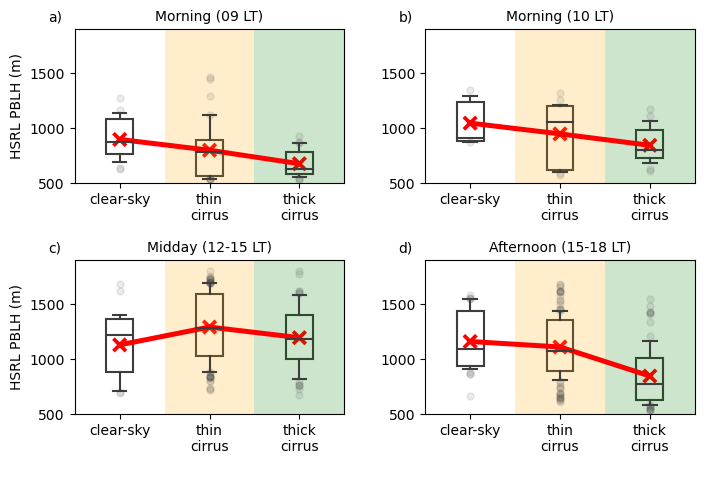

In [25]:
a4_dims = (8,5)
fig = plt.figure(figsize=a4_dims)
gs = fig.add_gridspec(2, 2,wspace=0.3,hspace=0.5)

####################################################################################################################################
df_pbl_cod_spn.loc[(df_pbl_cod_spn['hr_LT'] ==9), 'period'] = '09'
df_pbl_cod_spn.loc[(df_pbl_cod_spn['hr_LT'] ==10), 'period'] = '10'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['hr_LT'] >=12) & (df_pbl_cod_spn['hr_LT'] <=14)), 'period'] = '12-15'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['hr_LT'] >=15) & (df_pbl_cod_spn['hr_LT'] <18)), 'period'] = '15-18'

df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '09') & (df_pbl_cod_spn['od_group'] == 'clear')), 
                   'class'] = 'clear morning 09 LT'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '10') & (df_pbl_cod_spn['od_group'] == 'clear')), 
                   'class'] = 'clear morning 10 LT'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '12-15') & (df_pbl_cod_spn['od_group'] == 'clear')), 
                   'class'] = 'clear midday'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '15-18') & (df_pbl_cod_spn['od_group'] == 'clear')), 
                   'class'] = 'clear afternoon'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '09') & (df_pbl_cod_spn['od_group'] == 'thin')), 
                   'class'] = 'thin morning 09 LT'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '10') & (df_pbl_cod_spn['od_group'] == 'thin')), 
                   'class'] = 'thin morning 10 LT'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '12-15') & (df_pbl_cod_spn['od_group'] == 'thin')), 
                   'class'] = 'thin midday'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '15-18') & (df_pbl_cod_spn['od_group'] == 'thin')), 
                   'class'] = 'thin afternoon'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '09') & (df_pbl_cod_spn['od_group'] == 'thick')), 
                   'class'] = 'thick morning 09 LT'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '10') & (df_pbl_cod_spn['od_group'] == 'thick')), 
                   'class'] = 'thick morning 10 LT'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '12-15') & (df_pbl_cod_spn['od_group'] == 'thick')), 
                   'class'] = 'thick midday'
df_pbl_cod_spn.loc[((df_pbl_cod_spn['period'] == '15-18') & (df_pbl_cod_spn['od_group'] == 'thick')), 
                   'class'] = 'thick afternoon'

####################################################################################################################################
df_period = df_pbl_cod_spn
df_period = df_period[df_period['od_group']!="clear_no"]
df_period = df_period[df_period['od_group']!="atten"]
df_period = df_period[(df_period['class']=='clear morning 09 LT')  
                      | (df_period['class']=='thin morning 09 LT') 
                      | (df_period['class']=='thick morning 09 LT')]
order=["clear morning 09 LT", "thin morning 09 LT","thick morning 09 LT"]
ax = fig.add_subplot(gs[0,0])
ax.text(-0.1, 1.05,  'a)', fontsize=10, color='k', transform=ax.transAxes)

bplot = sns.boxplot(x="class", y="value", data=df_period, width=0.3,  boxprops=dict(facecolor='white'),   
                    whis=[10, 90], showfliers=True, flierprops=flierprops, order=order)

with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(x="class", y='value', data=df_period.groupby("class", as_index=False).mean(),
                  ax=ax, markers='x',scale=2, color='red', order=order)
    
ax.axvspan(0.5, 1.5, facecolor='orange', alpha=0.2)    
ax.axvspan(1.5, 2.5, facecolor='green', alpha=0.2)  
plt.yticks(fontsize=10)
plt.ylabel('HSRL PBLH (m)', fontsize=10)
plt.xlabel(' ')
plt.title('Morning (09 LT)',fontsize=10)
plt.xticks(ticks=[0, 1, 2], labels=["clear-sky", "thin\ncirrus", 
                                                      "thick\ncirrus"],fontsize=10)
ax.set_ylim(500,1900)
####################################################################################################################################
df_period = df_pbl_cod_spn
df_period = df_period[df_period['od_group']!="clear_no"]
df_period = df_period[df_period['od_group']!="atten"]
df_period = df_period[(df_period['class']=='clear morning 10 LT')  
                      | (df_period['class']=='thin morning 10 LT') 
                      | (df_period['class']=='thick morning 10 LT')]
order=["clear morning 10 LT", "thin morning 10 LT","thick morning 10 LT"]
ax = fig.add_subplot(gs[0,1])
ax.text(-0.1, 1.05,  'b)', fontsize=10, color='k', transform=ax.transAxes)

bplot = sns.boxplot(x="class", y="value", data=df_period, width=0.3,  boxprops=dict(facecolor='white'),   
                    whis=[10, 90], showfliers=True, flierprops=flierprops, order=order)

with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(x="class", y='value', data=df_period.groupby("class", as_index=False).mean(),
                  ax=ax, markers='x',scale=2, color='red', order=order)
    
ax.axvspan(0.5, 1.5, facecolor='orange', alpha=0.2)    
ax.axvspan(1.5, 2.5, facecolor='green', alpha=0.2)  
plt.yticks(fontsize=10)
plt.ylabel('', fontsize=10)
plt.xlabel(' ')
plt.title('Morning (10 LT)',fontsize=10)
plt.xticks(ticks=[0, 1, 2], labels=["clear-sky", "thin\ncirrus", 
                                                      "thick\ncirrus"],fontsize=10)
ax.set_ylim(500,1900)
####################################################################################################################################
df_period = df_pbl_cod_spn
df_period = df_period[df_period['od_group']!="clear_no"]
df_period = df_period[df_period['od_group']!="atten"]
df_period = df_period[(df_period['class']=='clear midday') | (df_period['class']=='thin midday') 
                      | (df_period['class']=='thick midday')]
order=["clear midday", "thin midday","thick midday"]
ax = fig.add_subplot(gs[1,0])
ax.text(-0.1, 1.05,  'c)', fontsize=10, color='k', transform=ax.transAxes)

bplot = sns.boxplot(x="class", y="value", data=df_period, width=0.3,  boxprops=dict(facecolor='white'),   
                    whis=[10, 90], showfliers=True, flierprops=flierprops, order=order)

with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(x="class", y='value', data=df_period.groupby("class", as_index=False).mean(),
                  ax=ax, markers='x',scale=2, color='red', order=order)
    
ax.axvspan(0.5, 1.5, facecolor='orange', alpha=0.2)    
ax.axvspan(1.5, 2.5, facecolor='green', alpha=0.2)  
plt.yticks(fontsize=15)
plt.yticks(fontsize=10)
plt.ylabel('HSRL PBLH (m)', fontsize=10)
plt.xlabel(' ')
plt.title('Midday (12-15 LT)',fontsize=10)
plt.xticks(ticks=[0, 1, 2], labels=["clear-sky", "thin\ncirrus", 
                                                      "thick\ncirrus"],fontsize=10)
ax.set_ylim(500,1900)
#########################################################################################################
df_period = df_pbl_cod_spn
df_period = df_period[df_period['od_group']!="clear_no"]
df_period = df_period[df_period['od_group']!="atten"]
df_period = df_period[(df_period['class']=='clear afternoon') | (df_period['class']=='thin afternoon') 
                      | (df_period['class']=='thick afternoon')]
order=["clear afternoon", "thin afternoon","thick afternoon"]
ax = fig.add_subplot(gs[1,1])
ax.text(-0.1, 1.05,  'd)', fontsize=10, color='k', transform=ax.transAxes)

bplot = sns.boxplot(x="class", y="value", data=df_period, width=0.3,  boxprops=dict(facecolor='white'),   
                    whis=[10, 90], showfliers=True, flierprops=flierprops, order=order)

with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(x="class", y='value', data=df_period.groupby("class", as_index=False).mean(),
                  ax=ax, markers='x',scale=2, color='red', order=order)
    
ax.axvspan(0.5, 1.5, facecolor='orange', alpha=0.2)    
ax.axvspan(1.5, 2.5, facecolor='green', alpha=0.2)  

plt.yticks(fontsize=10)
plt.ylabel('', fontsize=10)
plt.xlabel(' ')
plt.title('Afternoon (15-18 LT)',fontsize=10)
plt.xticks(ticks=[0, 1, 2], labels=["clear-sky", "thin\ncirrus", 
                                                      "thick\ncirrus"],fontsize=10)
ax.set_ylim(500,1900)
#########################################################################################################

output_filename = f'JGR_Paper_img/Figure8_JGRPaper.png'
plt.savefig(output_filename, dpi= 300, bbox_inches="tight")